In [2]:
simport pd
!pip install opencv-python


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [14]:
### Importing necessary libraries
import os
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import (VGG16, VGG19, ResNet50, InceptionV3, MobileNetV2,DenseNet121, Xception)
from keras.applications.efficientnet import (EfficientNetB0, EfficientNetB1, EfficientNetB2,EfficientNetB3, EfficientNetB4, EfficientNetB5,EfficientNetB6, EfficientNetB7, preprocess_input as efficientnet_preprocess_input)
from keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
from keras.applications.vgg19 import preprocess_input as vgg19_preprocess_input
from keras.applications.resnet50 import preprocess_input as resnet50_preprocess_input
from keras.applications.inception_v3 import preprocess_input as inceptionv3_preprocess_input
from keras.applications.mobilenet_v2 import preprocess_input as mobilenetv2_preprocess_input
from keras.applications.densenet import preprocess_input as densenet_preprocess_input
from keras.applications.xception import preprocess_input as xception_preprocess_input
from keras.layers import GlobalAveragePooling2D, Dense
from keras.models import Model
from keras.layers import BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense
import matplotlib.pyplot as plt
import seaborn as sns
from keras.optimizers import Adam
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score, precision_score
import cv2
import random
from pathlib import Path
import shutil
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model
from sklearn.metrics import roc_curve, auc
import warnings
# Import necessary libraries
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
from sklearn.metrics import roc_curve, auc
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
import warnings
from sklearn.exceptions import UndefinedMetricWarning

In [2]:

# Model configurations
num_classes = 2
batch_size = 32
epochs = 10

In [3]:
# Map model names to their function, preprocess_input, and input_shape
model_info = {
    'VGG16': (VGG16, vgg16_preprocess_input, (224, 224, 3)),
    'VGG19': (VGG19, vgg19_preprocess_input, (224, 224, 3)),
    'ResNet50': (ResNet50, resnet50_preprocess_input, (224, 224, 3)),
    'InceptionV3': (InceptionV3, inceptionv3_preprocess_input, (299, 299, 3)),
    'MobileNetV2': (MobileNetV2, mobilenetv2_preprocess_input, (224, 224, 3)),
    'DenseNet121': (DenseNet121, densenet_preprocess_input, (224, 224, 3)),
    'Xception': (Xception, xception_preprocess_input, (299, 299, 3)),
    'EfficientNetB0': (EfficientNetB0, efficientnet_preprocess_input, (224, 224, 3)),
    'EfficientNetB1': (EfficientNetB1, efficientnet_preprocess_input, (240, 240, 3)),
    'EfficientNetB2': (EfficientNetB2, efficientnet_preprocess_input, (260, 260, 3)),
    'EfficientNetB3': (EfficientNetB3, efficientnet_preprocess_input, (224, 224, 3)),
    'EfficientNetB4': (EfficientNetB4, efficientnet_preprocess_input, (224, 224, 3)),
    'EfficientNetB5': (EfficientNetB5, efficientnet_preprocess_input, (224, 224, 3)),
    'EfficientNetB6': (EfficientNetB6, efficientnet_preprocess_input, (224, 224, 3)),
    'EfficientNetB7': (EfficientNetB7, efficientnet_preprocess_input, (224, 224, 3))
}

In [4]:
# Set the data directory, batch size, and number of classes
DATA_DIR = "C:/Users/ahmed/Desktop/Caries Detection/teeth_dataset"
BATCH_SIZE = 16
NUM_CLASSES = 2
IMG_SIZE = (256, 256, 3)

In [5]:
# Data augmentation and generators
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE[:2],
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE[:2],
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 598 images belonging to 2 classes.
Found 149 images belonging to 2 classes.


In [6]:
# Attention U-Net architecture
def conv_block(x, num_filters):
    x = L.Conv2D(num_filters, 3, padding="same")(x)
    x = L.BatchNormalization()(x)
    x = L.Activation("relu")(x)
    x = L.Conv2D(num_filters, 3, padding="same")(x)
    x = L.BatchNormalization()(x)
    x = L.Activation("relu")(x)
    return x

def encoder_block(x, num_filters):
    x = conv_block(x, num_filters)
    p = L.MaxPool2D((2, 2))(x)
    return x, p

def attention_gate(g, s, num_filters):
    Wg = L.Conv2D(num_filters, 1, padding="same")(g)
    Wg = L.BatchNormalization()(Wg)
    Ws = L.Conv2D(num_filters, 1, padding="same")(s)
    Ws = L.BatchNormalization()(Ws)
    out = L.Activation("relu")(Wg + Ws)
    out = L.Conv2D(num_filters, 1, padding="same")(out)
    out = L.Activation("sigmoid")(out)
    return out * s

def decoder_block(x, s, num_filters):
    x = L.UpSampling2D(interpolation="bilinear")(x)
    s = attention_gate(x, s, num_filters)
    x = L.Concatenate()([x, s])
    x = conv_block(x, num_filters)
    return x

def modified_attention_unet(input_shape):
    inputs = L.Input(input_shape)
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    b1 = conv_block(p3, 512)
    return Model(inputs, b1, name="Modified-Attention-UNET")

def build_combined_model(input_shape):
    base_model = modified_attention_unet(input_shape)

    # Transitional Layer to adapt the U-Net output to VGG16 input
    transitional_layer = L.Conv2D(3, (1, 1), activation='relu', name='transitional_layer')(base_model.output)

    # Resize the output to match the input size expected by VGG16
    resize_layer = L.Resizing(32, 32, name='resize_layer')(transitional_layer)

    # Pre-trained model
    pretrained_model = VGG16(include_top=False, weights='imagenet', input_shape=(32, 32, 3))
    pretrained_model.trainable = False

    # Combine the models
    x = resize_layer
    x = pretrained_model(x)
    x = L.Flatten()(x)
    x = L.Dense(1024, activation='relu')(x)
    x = L.Dense(NUM_CLASSES, activation='softmax')(x)

    return Model(base_model.input, x)

In [7]:
# Metrics for model evaluation
METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

In [8]:
# Create and compile the combined model
combined_model = build_combined_model(IMG_SIZE)
combined_model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=METRICS)

model_name = 'VGG16'  # Give your model a name
checkpoint = ModelCheckpoint(filepath=f'{model_name}_model.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, min_delta=0.0001, min_lr=0.0001)
callbacks = [checkpoint, earlystop, reduce_lr]


In [9]:

# Train the model
history = combined_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=10,
    callbacks=callbacks
)

Epoch 1/10


37/37 [==============================] - ETA: 0s - loss: 0.3022 - accuracy: 0.9244 - precision: 0.9244 - recall: 0.9244 
Epoch 1: val_accuracy improved from -inf to 0.93750, saving model to VGG16_model.h5


C:\Users\ahmed\Desktop\Caries Detection\venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


37/37 [==============================] - 671s 18s/step - loss: 0.3022 - accuracy: 0.9244 - precision: 0.9244 - recall: 0.9244 - val_loss: 0.2385 - val_accuracy: 0.9375 - val_precision: 0.9375 - val_recall: 0.9375 - lr: 0.0010
Epoch 2/10
37/37 [==============================] - ETA: 0s - loss: 0.2394 - accuracy: 0.9313 - precision: 0.9313 - recall: 0.9313 
Epoch 2: val_accuracy did not improve from 0.93750
37/37 [==============================] - 660s 18s/step - loss: 0.2394 - accuracy: 0.9313 - precision: 0.9313 - recall: 0.9313 - val_loss: 0.5272 - val_accuracy: 0.9375 - val_precision: 0.9375 - val_recall: 0.9375 - lr: 0.0010
Epoch 3/10
37/37 [==============================] - ETA: 0s - loss: 0.2429 - accuracy: 0.9296 - precision: 0.9296 - recall: 0.9296 
Epoch 3: val_accuracy improved from 0.93750 to 0.95139, saving model to VGG16_model.h5
37/37 [==============================] - 650s 18s/step - loss: 0.2429 - accuracy: 0.9296 - precision: 0.9296 - recall: 0.9296 - val_loss: 0.2074 -

In [12]:
# Model evaluation
test_loss, test_acc = combined_model.evaluate(validation_generator, steps=len(validation_generator))
print(f"Test accuracy: {test_acc:.2f}")

10/10 [==============================] - 48s 5s/step - loss: 0.2515 - accuracy: 0.9396 - precision: 0.9396 - recall: 0.9396


ValueError: too many values to unpack (expected 2)

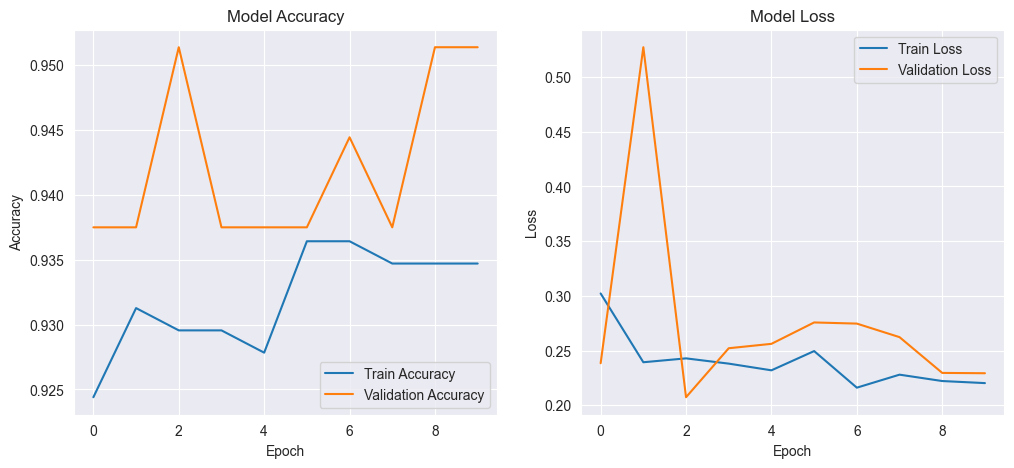

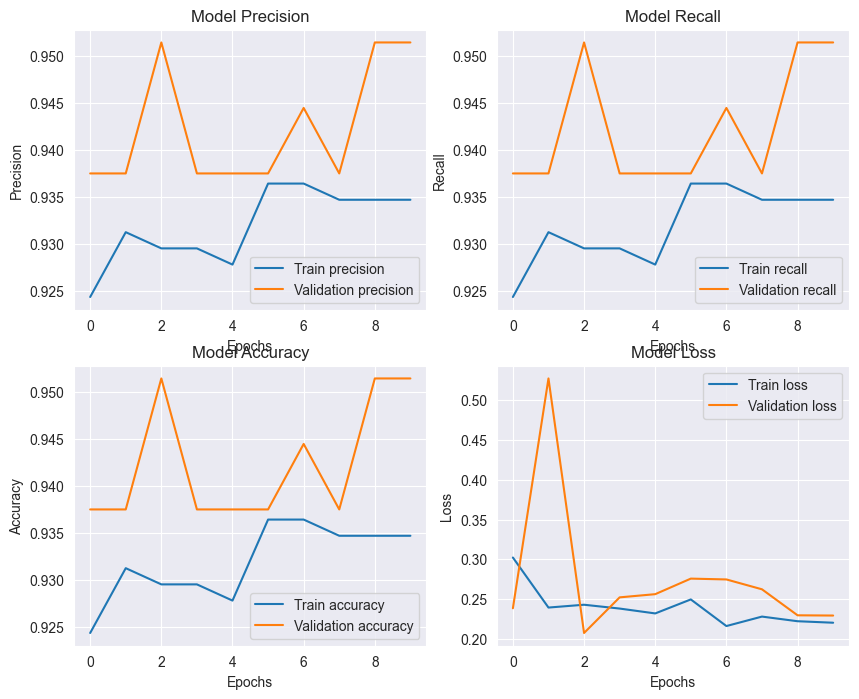

10/10 [==============================] - 32s 3s/step - loss: 0.2437 - accuracy: 0.9396 - precision: 0.9396 - recall: 0.9396
Validation Loss: 0.24372246861457825
Validation Accuracy: 0.9395973086357117
Validation Precision: 0.9395973086357117
Validation Recall: 0.9395973086357117
1/1 [==============================] - 1s 1s/step
True labels shape: (149,), unique values: [0 1]
Predictions shape: (149,), unique values: [0]


In [16]:
# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.savefig(f'{model_name}_accuracy_loss_plot.png')
plt.show()

# Plot precision, recall, accuracy, loss
fig, ax = plt.subplots(2, 2, figsize=(10, 8))
ax = ax.ravel()

for i, metric in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[metric], label='Train ' + metric)
    ax[i].plot(history.history['val_' + metric], label='Validation ' + metric)
    ax[i].set_title('Model ' + metric.capitalize())
    ax[i].set_xlabel('Epochs')
    ax[i].set_ylabel(metric.capitalize())
    ax[i].legend()

fig.savefig(f'{model_name}_metrics.png')
plt.show()

# Evaluate the model
loss, accuracy, precision, recall = combined_model.evaluate(validation_generator)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")
print(f"Validation Precision: {precision}")
print(f"Validation Recall: {recall}")

true_labels = []
predictions = []

# Iterate over the validation generator
for x, y in validation_generator:
    true_batch_labels = np.argmax(y, axis=1)

#     print(true_batch_labels)

    true_labels.extend(true_batch_labels)

    # Predict and process predictions
    pred_batch = combined_model.predict(x)
    pred_batch_labels = np.argmax(pred_batch, axis=-1)  # Ensure this axis is correct
#     print(pred_batch_labels)
    predictions.extend(pred_batch_labels)

    if len(true_labels) >= validation_generator.samples:
        break

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predictions = np.array(predictions)

# Check shapes and values
print(f"True labels shape: {true_labels.shape}, unique values: {np.unique(true_labels)}")
print(f"Predictions shape: {predictions.shape}, unique values: {np.unique(predictions)}")








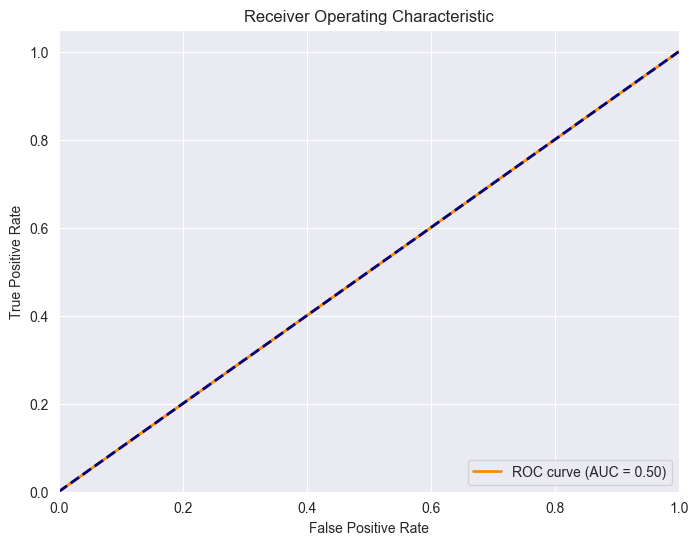

In [17]:
# Visualize ROC curve and AUC
fpr, tpr, thresholds = roc_curve(validation_generator.classes, predictions)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

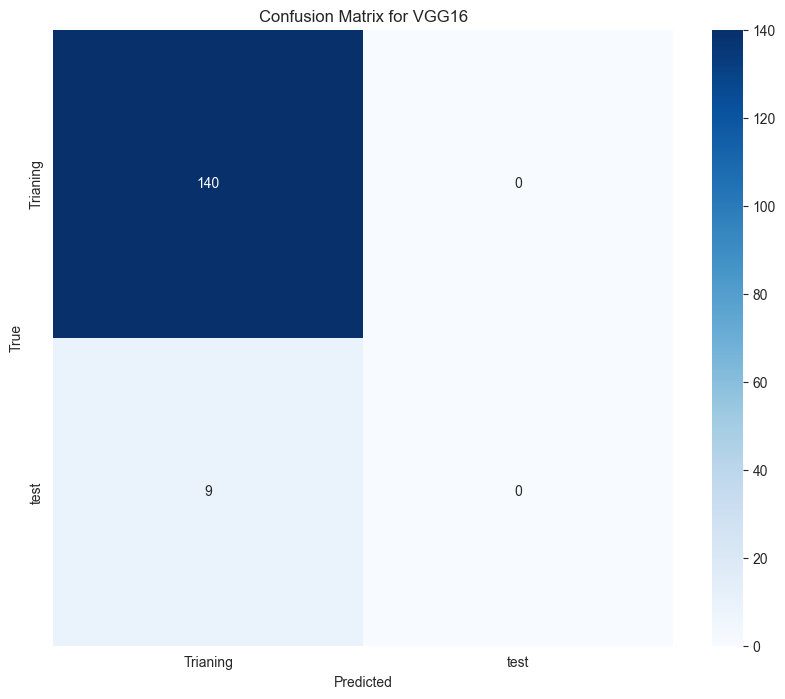

      Class  True Positives (TP)  True Negatives (TN)  False Positives (FP)  \
0  Trianing                  140                    0                     9   
1      test                    0                  140                     0   

   False Negatives (FN)  
0                     0  
1                     9  
Metrics saved to VGG16_confusion_matrix_metrics.csv


In [18]:
# Compute the confusion matrix
try:
    cm = confusion_matrix(true_labels, predictions)
except ValueError as e:
    print(f"Error computing confusion matrix: {e}")
    print(f"True labels: {true_labels}")
    print(f"Predictions: {predictions}")
    raise
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=validation_generator.class_indices.keys(), yticklabels=validation_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix for {model_name}')
plt.savefig(f'{model_name}_confusion_matrix.png')
plt.show()

# Calculate TP, FP, TN, FN
tp = np.diag(cm)
fp = cm.sum(axis=0) - tp
fn = cm.sum(axis=1) - tp
tn = cm.sum() - (fp + fn + tp)

# Convert to a DataFrame for easy handling and visualization
df_metrics = pd.DataFrame({'Class': list(validation_generator.class_indices.keys()),
                           'True Positives (TP)': tp,
                           'True Negatives (TN)': tn,
                           'False Positives (FP)': fp,
                           'False Negatives (FN)': fn})

# Display the DataFrame
print(df_metrics)
# Save TP, TN, FP, FN to CSV file
metrics_file = f'{model_name}_confusion_matrix_metrics.csv'
df_metrics.to_csv(metrics_file, index=False)

print(f"Metrics saved to {metrics_file}")

In [19]:
# Evaluation Metrics
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1score = f1_score(true_labels, predictions, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1score)

Accuracy: 0.9395973154362416
Precision: 0.882843115174992
Recall: 0.9395973154362416
F1-Score: 0.9103364993845939


In [20]:
# Save metrics to CSV
csv_file = 'model_results.csv'
new_row = pd.DataFrame([[model_name, accuracy, precision, recall, f1score]], columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])
if not os.path.exists(csv_file):
    new_row.to_csv(csv_file, index=False)
else:
    pd.concat([pd.read_csv(csv_file), new_row]).to_csv(csv_file, index=False)


In [21]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model

# Assuming your modified Attention U-Net model is named 'modified_attention_unet'
# and it is already defined and compiled in your environment.

# Load the model
input_shape = (256, 256, 3)  # Adjust this if necessary
feature_extractor = modified_attention_unet(input_shape)
feature_extractor.summary()  # Check if the model is loaded correctly

# Directory paths
build_dir = "C:/Users/ahmed/Desktop/Caries Detection/teeth_dataset/Trianing"
class_dirs = ['caries','without_caries']

selected_images = []
for class_dir in class_dirs:
    path = os.path.join(build_dir, class_dir)
    images = os.listdir(path)
    selected_image = np.random.choice(images)
    selected_images.append(os.path.join(path, selected_image))

# Function to preprocess the image
def preprocess_image(image_path, target_size):
    img = load_img(image_path, target_size=target_size)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img /= 255.0
    return img


Model: "Modified-Attention-UNET"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_8 (Conv2D)           (None, 256, 256, 64)      1792      
                                                                 
 batch_normalization_8 (Bat  (None, 256, 256, 64)      256       
 chNormalization)                                                
                                                                 
 activation_8 (Activation)   (None, 256, 256, 64)      0         
                                                                 
 conv2d_9 (Conv2D)           (None, 256, 256, 64)      36928     
                                                                 
 batch_normalization_9 (Bat  (None, 256, 256, 64)      256       
 chNormalization)                          

1/1 [==============================] - 0s 488ms/step


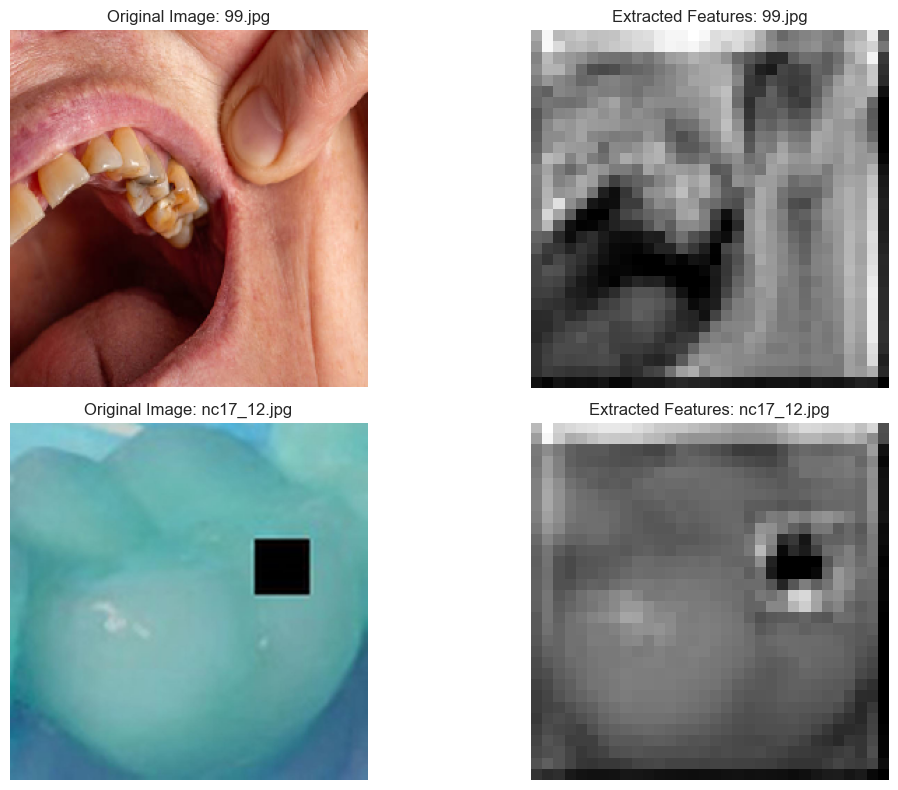

In [22]:

# Visualize original and extracted features
plt.figure(figsize=(12, 4 * len(selected_images)))
for i, image_path in enumerate(selected_images):
    # Original Image
    original_img = load_img(image_path, target_size=(256, 256))
    plt.subplot(len(selected_images), 2, 2*i + 1)
    plt.imshow(original_img)
    plt.title(f"Original Image: {os.path.basename(image_path)}")
    plt.axis('off')
    
    # Extract features
    preprocessed_img = preprocess_image(image_path, target_size=(256, 256))
    features = feature_extractor.predict(preprocessed_img)

    # Visualization of extracted features
    # Note: features.shape might vary, adjust the visualization accordingly
    plt.subplot(len(selected_images), 2, 2*i + 2)
    plt.imshow(features[0, :, :, 0], cmap='gray')  # Visualize the first channel of the features
    plt.title(f"Extracted Features: {os.path.basename(image_path)}")
    plt.axis('off')

plt.tight_layout()
plt.savefig("img.png")
plt.show()